In [1]:
import numpy as np
import pandas as pd
import pickle
import os
import cv2
import random
import skimage.morphology as morp
from skimage.filters import rank
import matplotlib.pyplot as plt
import tensorflow as tf
import dotscience as ds

In [2]:
ds.interactive()

In [3]:
# Show current TensorFlow version
tf.__version__


'1.12.0'

In [4]:
%%bash
DATAFILE="https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip"
if [ -d "/tmp/traffic-signs-data" ]; then
    echo "Data already downloaded"
else
    echo "Downloading data from $DATAFILE"
    mkdir /tmp/traffic-signs-data
    curl -s -o /tmp/traffic-signs-data/traffic-signs-data.zip $DATAFILE
    (cd /tmp/traffic-signs-data && unzip traffic-signs-data.zip && rm -f traffic-signs-data.zip)
fi


Data already downloaded


In [5]:
training_file = "/tmp/traffic-signs-data/train.p"
validation_file= "/tmp/traffic-signs-data/valid.p"
testing_file = "/tmp/traffic-signs-data/test.p"

ds.input(training_file)
ds.input(validation_file)
ds.input(testing_file)

train = pickle.load(open(training_file,"rb"))
valid = pickle.load(open(validation_file,"rb"))
test = pickle.load(open(testing_file,"rb"))




In [6]:
import csv
# Mapping ClassID to traffic sign names
signs = []
with open('signnames.csv', 'r') as csvfile:
    signnames = csv.reader(csvfile, delimiter=',')
    next(signnames,None)
    for row in signnames:
        signs.append(row[1])
    csvfile.close()
    
ds.input("signnames.csv")

'signnames.csv'

In [7]:
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# Number of training examples
n_train = X_train.shape[0]

# Number of testing examples
n_test = X_test.shape[0]

# Number of validation examples.
n_validation = X_valid.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples: ", n_train)
print("Number of testing examples: ", n_test)
print("Number of validation examples: ", n_validation)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples:  34799
Number of testing examples:  12630
Number of validation examples:  4410
Image data shape = (32, 32, 3)
Number of classes = 43


In [8]:
X_train[0].shape

(32, 32, 3)

# preprocess data

In [9]:
# define helper functions
def list_images(dataset, dataset_y, ylabel="", cmap=None):
    """
    Display a list of images in a single figure with matplotlib.
        Parameters:
            images: An np.array compatible with plt.imshow.
            lanel (Default = No label): A string to be used as a label for each image.
            cmap (Default = None): Used to display gray images.
    """
    plt.figure(figsize=(15, 16))
    for i in range(6):
        plt.subplot(1, 6, i+1)
        indx = random.randint(0, len(dataset))
        #Use gray scale color map if there is only one channel
        cmap = 'gray' if len(dataset[indx].shape) == 2 else cmap
        plt.imshow(dataset[indx], cmap = cmap)
        plt.xlabel(signs[dataset_y[indx]])
        plt.ylabel(ylabel)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()
    
def histogram_plot(dataset, label):
    """
    Plots a histogram of the input data.
        Parameters:
            dataset: Input data to be plotted as a histogram.
            lanel: A string to be used as a label for the histogram.
    """
    hist, bins = np.histogram(dataset, bins=n_classes)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    plt.xlabel(label)
    plt.ylabel("Image count")
    plt.show()
    
def gray_scale(image):
    """
    Convert images to gray scale.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def local_histo_equalize(image):
    """
    Apply local histogram equalization to grayscale images.
        Parameters:
            image: A grayscale image.
    """
    kernel = morp.disk(30)
    img_local = rank.equalize(image, selem=kernel)
    return img_local

def image_normalize(image):
    """
    Normalize images to [0, 1] scale.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    image = np.divide(image, 255)
    return image

def preprocess(data):
    """
    Applying the preprocessing steps to the input data.
        Parameters:
            data: An np.array compatible with plt.imshow.
    """
    gray_images = list(map(gray_scale, data))
    equalized_images = list(map(local_histo_equalize, gray_images))
    n_training = data.shape
    normalized_images = np.zeros((n_training[0], n_training[1], n_training[2]))
    for i, img in enumerate(equalized_images):
        normalized_images[i] = image_normalize(img)
    normalized_images = normalized_images[..., None]
    return normalized_images

In [10]:
X_valid_preprocessed = preprocess(X_valid)
X_test_preprocessed = preprocess(X_test)
X_train_preprocessed = preprocess(X_train)

In [11]:
# list_images(X_train_preprocessed, y_train)

# make model

In [15]:
num_classes=43
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=(32, 32, 1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(tf.keras.layers.Conv2D(32, (5, 5), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1000, activation='relu'))
model.add(tf.keras.layers.Dense(units = num_classes, activation='softmax'))

model.compile(optimizer=ds.parameter("optimizer", 'adam'),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='acc')

model.fit(X_train_preprocessed, y_train,
          epochs=ds.parameter("epochs", 100),
          verbose=1,
          validation_data=(X_valid_preprocessed, y_valid),
          callbacks=[es])

Train on 34799 samples, validate on 4410 samples
Epoch 1/100
34799/34799 [==============================] - 4s 125us/step - loss: 0.6925 - acc: 0.8064 - val_loss: 0.2828 - val_acc: 0.9179
Epoch 2/100
34799/34799 [==============================] - 4s 114us/step - loss: 0.1095 - acc: 0.9683 - val_loss: 0.2251 - val_acc: 0.9340
Epoch 3/100
34799/34799 [==============================] - 4s 112us/step - loss: 0.0555 - acc: 0.9841 - val_loss: 0.2128 - val_acc: 0.9429
Epoch 4/100
34799/34799 [==============================] - 4s 112us/step - loss: 0.0411 - acc: 0.9876 - val_loss: 0.1988 - val_acc: 0.9485
Epoch 5/100
34799/34799 [==============================] - 4s 112us/step - loss: 0.0342 - acc: 0.9896 - val_loss: 0.2870 - val_acc: 0.9306
Epoch 6/100
34799/34799 [==============================] - 4s 112us/step - loss: 0.0306 - acc: 0.9907 - val_loss: 0.1923 - val_acc: 0.9501
Epoch 7/100
34799/34799 [==============================] - 4s 112us/step - loss: 0.0201 - acc: 0.9937 - val_loss: 0.1

In [16]:
model.evaluate(X_test_preprocessed, y_test)

12630/12630 [==============================] - 1s 47us/step


[0.4551715929795614, 0.9190815518795264]

In [17]:
ds.summary("accuracy", model.evaluate(X_test_preprocessed, y_test)[1])

12630/12630 [==============================] - 1s 47us/step


0.9190815518795264

# Sanity check predictions

In [18]:
model.predict(X_test_preprocessed).shape

(12630, 43)

In [19]:
predictions = pd.DataFrame(data=model.predict(X_test_preprocessed))

In [20]:
predictions.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0.000000e+00,0.000000e+00,2.159056e-35,4.823136e-27,2.471685e-32,8.535417e-14,2.041862e-35,1.314291e-16,1.126326e-33,9.061286e-12,...,6.970119e-31,0.000000e+00,9.605378e-22,1.773956e-32,2.242482e-25,2.036040e-32,1.697348e-27,3.178313e-15,7.080307e-33,2.597204e-29
1,1.283989e-10,9.963673e-01,3.239854e-03,7.388196e-11,6.807251e-10,3.585807e-04,1.713010e-05,1.460022e-05,9.734922e-13,1.135939e-16,...,3.128155e-12,1.194699e-16,1.146797e-11,1.513021e-11,1.363647e-12,2.689255e-10,4.735400e-13,3.128137e-08,6.946134e-14,3.816856e-09
2,2.802987e-37,1.109092e-23,6.117242e-30,5.240105e-30,0.000000e+00,8.470579e-33,5.268023e-38,0.000000e+00,8.134854e-36,9.926313e-37,...,0.000000e+00,6.394906e-25,0.000000e+00,8.981929e-27,0.000000e+00,1.000000e+00,0.000000e+00,2.214493e-33,0.000000e+00,0.000000e+00
3,1.678916e-34,3.515338e-18,3.149775e-23,8.795029e-30,1.985448e-37,1.202124e-22,3.338843e-36,1.076737e-25,3.092067e-33,6.961644e-20,...,1.000000e+00,6.812834e-22,8.358407e-23,3.880245e-33,1.324164e-21,2.070822e-26,3.622578e-22,6.111989e-24,4.733897e-37,1.032092e-33
4,9.163435e-38,5.495246e-24,3.435799e-29,3.039237e-38,0.000000e+00,2.938356e-23,2.658953e-29,3.285590e-27,1.838138e-38,0.000000e+00,...,3.496816e-32,1.573456e-36,0.000000e+00,0.000000e+00,0.000000e+00,6.379159e-35,0.000000e+00,5.911611e-26,3.781360e-34,3.705494e-26


In [21]:
column_mapper = {}
f = csv.reader(open("signnames.csv"))
next(f) # skip header
counter = 0
for row in f:
    print(row)
    signname = row[1]
    column_mapper[counter] = signname
    counter += 1
    

['0', 'Speed limit (20km/h)']
['1', 'Speed limit (30km/h)']
['2', 'Speed limit (50km/h)']
['3', 'Speed limit (60km/h)']
['4', 'Speed limit (70km/h)']
['5', 'Speed limit (80km/h)']
['6', 'End of speed limit (80km/h)']
['7', 'Speed limit (100km/h)']
['8', 'Speed limit (120km/h)']
['9', 'No passing']
['10', 'No passing for vehicles over 3.5 metric tons']
['11', 'Right-of-way at the next intersection']
['12', 'Priority road']
['13', 'Yield']
['14', 'Stop']
['15', 'No vehicles']
['16', 'Vehicles over 3.5 metric tons prohibited']
['17', 'No entry']
['18', 'General caution']
['19', 'Dangerous curve to the left']
['20', 'Dangerous curve to the right']
['21', 'Double curve']
['22', 'Bumpy road']
['23', 'Slippery road']
['24', 'Road narrows on the right']
['25', 'Road work']
['26', 'Traffic signals']
['27', 'Pedestrians']
['28', 'Children crossing']
['29', 'Bicycles crossing']
['30', 'Beware of ice/snow']
['31', 'Wild animals crossing']
['32', 'End of all speed and passing limits']
['33', 'Turn 

In [22]:
predictions = predictions.rename(columns=column_mapper)

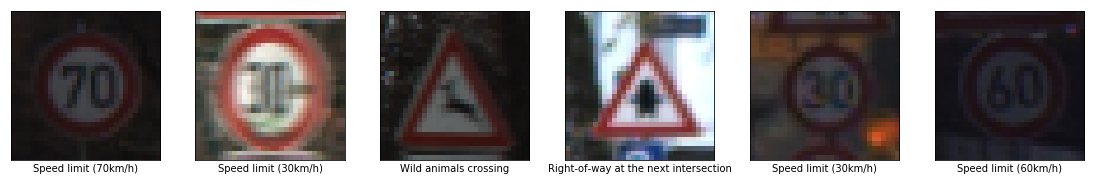

In [23]:
list_images(X_test, y_test)


In [24]:
def list_image(dataset, index, cmap=None):
    """
    Display a list of images in a single figure with matplotlib.
        Parameters:
            images: An np.array compatible with plt.imshow.
            lanel (Default = No label): A string to be used as a label for each image.
            cmap (Default = None): Used to display gray images.
    """
    plt.figure(figsize=(10, 16))
    plt.subplot()
    #Use gray scale color map if there is only one channel
    cmap = 'gray' if len(dataset[index].shape) == 2 else cmap
    plt.imshow(dataset[index], cmap = cmap)
    #plt.xlabel(signs[dataset_y[indx]])
    #plt.ylabel(ylabel)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

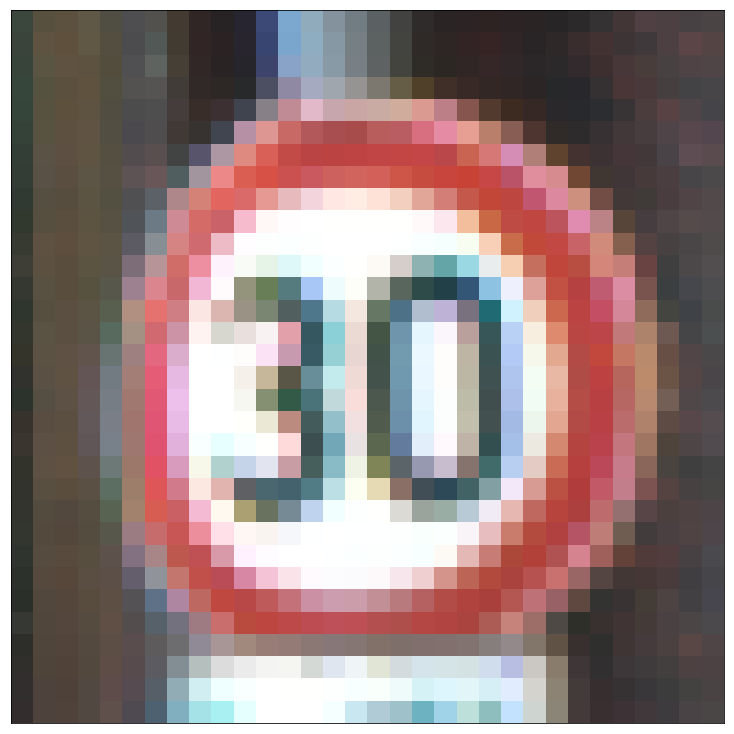

In [25]:
list_image(X_test, 1)

In [26]:
pd.DataFrame({n: predictions.T[col].nlargest(1).index.tolist() 
                  for n, col in enumerate(predictions.T)}).T

,0
0,Vehicles over 3.5 metric tons prohibited
1,Speed limit (30km/h)
2,Keep right
3,Turn right ahead
4,Right-of-way at the next intersection
5,Keep right
6,General caution
7,Priority road
8,Road work
9,Ahead only


In [27]:
# Fetch the Keras session and save the model
# The signature definition is defined by the input and output tensors,
# and stored with the default serving key
import tempfile

MODEL_DIR = "./model"
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))
if os.path.isdir(export_path):
  print('\nAlready saved a model, cleaning up\n')
  !rm -r {export_path}

tf.saved_model.simple_save(
    tf.keras.backend.get_session(),
    export_path,
    inputs={'input_image': model.input},
    outputs={t.name:t for t in model.outputs})

print('\nSaved model:')
!ls -l {export_path}

export_path = ./model/1


Already saved a model, cleaning up

Instructions for updating:
Pass your op to the equivalent parameter main_op instead.
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./model/1/saved_model.pb

Saved model:
total 1
-rw-r--r-- 1 root root 499658 Mar 14 20:50 saved_model.pb
drwxr-xr-x 2 root root      4 Mar 14 20:50 variables


In [28]:
!saved_model_cli show --dir {export_path} --all



MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_image'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 32, 32, 1)
        name: conv2d_6_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_7/Softmax:0'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 43)
        name: dense_7/Softmax:0
  Method name is: tensorflow/serving/predict


In [29]:
ds.label("model.directory", ds.output("model"))
ds.label("model.framework", "tensorflow")
ds.label("model.framework.version", tf.__version__)

'1.12.0'

In [30]:
ds.publish()

[[DOTSCIENCE-RUN:4f2009ba-13eb-47c3-9b97-a85ba7de3baf]]{
    "end": "20190314T205022.206765",
    "input": [
        "/tmp/traffic-signs-data/valid.p",
        "signnames.csv",
        "/tmp/traffic-signs-data/train.p",
        "/tmp/traffic-signs-data/test.p"
    ],
    "labels": {
        "model.directory": "model",
        "model.framework": "tensorflow",
        "model.framework.version": "1.12.0"
    },
    "output": [
        "model"
    ],
    "parameters": {
        "epochs": "100",
        "optimizer": "adam"
    },
    "start": "20190314T204341.796118",
    "summary": {
        "accuracy": "0.9190815518795264"
    },
    "version": "1"
}[[/DOTSCIENCE-RUN:4f2009ba-13eb-47c3-9b97-a85ba7de3baf]]
